In [1]:
from pathlib import Path
import statistics as stat

import pandas as pnd
import seaborn as sb

from helper_functions import *

# define main functions

In [2]:
def get_recovered_df(files):
    
    
    results_df = [] 
    for file in files:
    
        strain_id = Path(file).stem
        strain_id = strain_id.replace('_model', '')
        if '-draft' in strain_id: 
            continue    # Skip gapseq draft models

        if file.endswith('.xml'): 
            model = cobra.io.read_sbml_model(file)
        if file.endswith('.json'): 
            model = cobra.io.load_json_model(file)
            
            
        # reactions (no exchanges)
        rids = set([r.id for r in model.reactions if not (len(r.metabolites)==1 and list(r.metabolites)[0].id.rsplit('_', 1)[-1] in ['e', 'e0'])])
            
        # get recovered genes
        recG_ids = set()
        for g in model.genes: 
            if '_frag' in g.id or '_overlap' in g.id or '_refound' in g.id:
                recG_ids.add(g.id)     

        # get reactions lost when excluding recovered genes:
        model2 = model.copy()
        to_remove = [model2.genes.get_by_id(gid) for gid in recG_ids]
        cobra.manipulation.delete.remove_genes(model2, to_remove, remove_reactions=True)
        recR_ids = rids - set([r.id for r in model2.reactions])
                       
            
        results_df.append({'strain': strain_id, 'metric': 'recG', 'value': recG_ids})
        results_df.append({'strain': strain_id, 'metric': 'recR', 'value': recR_ids})
            
        print('▯', end='')  # loading bar

    results_df = pnd.DataFrame.from_records(results_df)
    return results_df

# main run

In [8]:
%%capture --no-stdout


for dataset in ['01_klebsiella', '02_ralstonia', '03_pseudomonas']:
    
    globber = f'{dataset}/tools_runs/gempipe/output/strain_models_gf/*.json'

    print(dataset, 'gempipe', end=': ') 
    res = parallelizer(globber, get_recovered_df, nthreads=37)
    print()

    res['tool'] = 'gempipe'
    res['dataset'] = dataset
        
    res.to_csv(f'{dataset}/tables/recovered.csv')
    

01_klebsiella gempipe: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia gempipe: ▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas gempipe: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯


# comput set lengths

In [3]:
recovered_01 = pnd.read_csv(f'01_klebsiella/tables/recovered.csv', index_col=0)
recovered_02 = pnd.read_csv(f'02_ralstonia/tables/recovered.csv', index_col=0)
recovered_03 = pnd.read_csv(f'03_pseudomonas/tables/recovered.csv', index_col=0)
recovered_all = pnd.concat([recovered_01, recovered_02, recovered_03])
recovered_all = recovered_all.reset_index(drop=True)


# 'value' col is str after reading; convert back to set:
for index, row in recovered_all.iterrows(): 
    recovered_all.loc[index, 'value'] = eval(recovered_all.loc[index, 'value'])


# compute set lengths
recovered_all['value_len'] = None
for index, row in recovered_all.iterrows(): 
    value_len = len(recovered_all.loc[index, 'value'])
    recovered_all.loc[index, 'value_len'] = value_len

In [4]:
recovered_all

,strain,metric,value,tool,dataset,value_len
0,Kp_SB1067,recG,"{HJMANCGA_frag_01544_01545, HJMANCGA_overlap_1...",gempipe,01_klebsiella,5
1,Kp_SB1067,recR,{},gempipe,01_klebsiella,0
2,Kp_T69,recG,"{CHMOKBPN_overlap_3, CHMOKBPN_overlap_22, CHMO...",gempipe,01_klebsiella,6
3,Kp_T69,recR,{NNAM},gempipe,01_klebsiella,1
4,Kp_SA1,recG,"{PIECHOEE_overlap_19, PIECHOEE_overlap_6, PIEC...",gempipe,01_klebsiella,7
...,...,...,...,...,...,...
163,DTR133,recR,"{DHPS, FOLD3, ATPS4rpp}",gempipe,03_pseudomonas,3
164,B25,recG,"{ILBEPPFA_overlap_15, ILBEPPFA_refound_10, ILB...",gempipe,03_pseudomonas,8
165,B25,recR,"{DHPS, OIVD2, OIVD1r, FOLD3, OIVD3}",gempipe,03_pseudomonas,5
166,M71,recG,"{LHFONHNJ_refound_18, LHFONHNJ_frag_02516_0251...",gempipe,03_pseudomonas,6


# separate recovery steps

Based of suffixes

In [5]:
new_rows = []
for index, row in recovered_all.iterrows():
    if row['metric']=='recG':
        gids = row['value']
        
        
        gids_frag = set([gid for gid in gids if '_frag' in gid ])
        new_rows.append({
            'strain': row['strain'],
            'metric': 'g_frag',
            'value': gids_frag,
            'tool': row['tool'],
            'dataset': row['dataset'],
            'value_len': len(gids_frag),
        })
        
        gids_refound = set([gid for gid in gids if '_refound' in gid ])
        new_rows.append({
            'strain': row['strain'],
            'metric': 'g_refound',
            'value': gids_refound,
            'tool': row['tool'],
            'dataset': row['dataset'],
            'value_len': len(gids_refound),
        })
        
        gids_overlap = set([gid for gid in gids if '_overlap' in gid ])
        new_rows.append({
            'strain': row['strain'],
            'metric': 'g_overlap',
            'value': gids_overlap,
            'tool': row['tool'],
            'dataset': row['dataset'],
            'value_len': len(gids_overlap),
        })                                                                   
        
new_rows = pnd.DataFrame.from_records(new_rows)
recovered_all = pnd.concat([new_rows, recovered_all]).reset_index(drop=True)


In [6]:
recovered_all

,strain,metric,value,tool,dataset,value_len
0,Kp_SB1067,g_frag,"{HJMANCGA_frag_01544_01545, HJMANCGA_frag_0036...",gempipe,01_klebsiella,2
1,Kp_SB1067,g_refound,{},gempipe,01_klebsiella,0
2,Kp_SB1067,g_overlap,"{HJMANCGA_overlap_12, HJMANCGA_overlap_13, HJM...",gempipe,01_klebsiella,3
3,Kp_T69,g_frag,"{CHMOKBPN_frag_03283_03284, CHMOKBPN_frag_0270...",gempipe,01_klebsiella,3
4,Kp_T69,g_refound,{},gempipe,01_klebsiella,0
...,...,...,...,...,...,...
415,DTR133,recR,"{DHPS, FOLD3, ATPS4rpp}",gempipe,03_pseudomonas,3
416,B25,recG,"{ILBEPPFA_overlap_15, ILBEPPFA_refound_10, ILB...",gempipe,03_pseudomonas,8
417,B25,recR,"{DHPS, OIVD2, OIVD1r, FOLD3, OIVD3}",gempipe,03_pseudomonas,5
418,M71,recG,"{LHFONHNJ_refound_18, LHFONHNJ_frag_02516_0251...",gempipe,03_pseudomonas,6


# plot recovered G/R

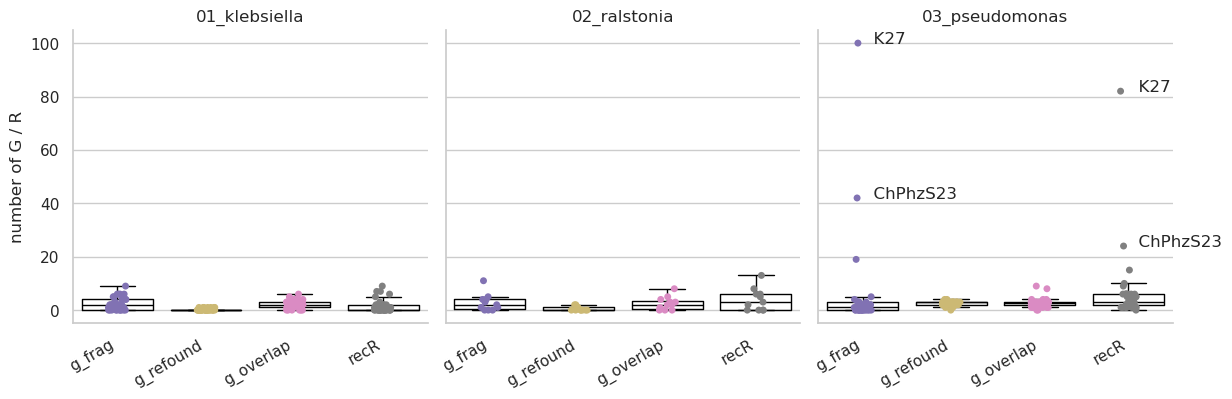

In [18]:
recovered_all = recovered_all[~ (recovered_all['metric']=='recG')]


sb.set_theme(style="whitegrid")

palette1 = {'g_frag': 'C4', 'g_refound': 'C8', 'g_overlap': 'C6', 'recR': 'grey'}
g = sb.FacetGrid(recovered_all, col="dataset",  height=4, aspect=1)

g = g.map_dataframe(
    sb.boxplot, x='metric', y='value_len',  fill=False, color='black', linewidth=1, fliersize=0)
g = g.map_dataframe(
    sb.stripplot, x='metric', y='value_len', hue='metric', palette=palette1)


g.set_axis_labels('', 'number of G / R')
#g.legend.set_title("")

g.set_xticklabels(rotation=30, ha='right')

axes = g.axes.flatten()
axes[0].set_title("01_klebsiella")
axes[1].set_title("02_ralstonia")
axes[2].set_title("03_pseudomonas")


for outlier in ['K27', 'ChPhzS23']:
    for x_coord, metric in zip([0,3], ['g_frag', 'recR']):
        
        axes[2].annotate(
            '  '+ outlier, 
            xy=(x_coord, recovered_all[(recovered_all['strain']==outlier) & (recovered_all['metric']==metric)]['value_len'].iloc[0])
        )

# Pseudomonas chlororaphis subsp. aurantiaca  K27        
# Pseudomonas chlororaphis subsp. aureofaciens ChPhzTR39

g

# Create supplementary tables

In [25]:
# suppl. table for recovered genes: 
with pnd.ExcelWriter('tables/Supplementary File 2.xlsx', engine='xlsxwriter') as writer:
    
    
    INFO = """
        Recovered genes in strain-specific GSMMs. 
        Cells contain gene IDs, rows contain gene cluster IDs where genes belong to; 
        columns contain strains.
    """
    data = [i.strip().rstrip() for i in INFO.strip().rstrip().split('\n')]
    df = pnd.DataFrame(data, columns=["INFO"])
    df.to_excel(writer, sheet_name='INFO', index=False)
    
        
    for dataset in recovered_all['dataset'].unique():

        focus_rec_Gs = recovered_all[(recovered_all['metric']=='recG') & (recovered_all['dataset']==dataset)]


        pam = pnd.read_csv(f'{dataset}/tools_runs/gempipe/output/pam.csv', index_col=0)
        cds_to_cluster = {}
        for cluster in pam.index: 
            for strain in pam.columns: 
                cell = pam.loc[cluster, strain]
                if type(cell)==float: continue
                for cds in cell.split(';'):
                    cds_to_cluster[cds] = cluster


        overall_recovered_clusters = set()
        for index, row in focus_rec_Gs.iterrows():
            for gene in row['value']:
                overall_recovered_clusters.add(cds_to_cluster[gene])


        res = pnd.DataFrame(index=list(overall_recovered_clusters), columns=focus_rec_Gs['strain'].unique())
        for cluster in res.index: 
            for strain in res.columns:
                res.loc[cluster, strain] = set()


        for index, row in focus_rec_Gs.iterrows():
            for gene in row['value']:
                res.loc[cds_to_cluster[gene], row['strain']].add(gene)
                
        for index in res.index:
            for col in res.columns:
                if res.loc[index, col]== set():
                    res.loc[index, col] = ' '
                else:
                    res.loc[index, col] = ','.join(list(res.loc[index, col]))
                
             
        res.to_excel(writer, sheet_name=dataset, index=True)

In [26]:
# suppl. table for recovered reactions: 
with pnd.ExcelWriter('tables/Supplementary File 3.xlsx', engine='xlsxwriter') as writer:
    
    
    INFO = """
        Reactions modeled in strain-specific GSMMs as consequence of gene recovery. 
        Rows contain reaction IDs, columns contain strains, 
        cells describe reaction presence (1) or absence in a particular strain.
    """
    data = [i.strip().rstrip() for i in INFO.strip().rstrip().split('\n')]
    df = pnd.DataFrame(data, columns=["INFO"])
    df.to_excel(writer, sheet_name='INFO', index=False)
    
        
    for dataset in recovered_all['dataset'].unique():
        

        focus_rec_Rs = recovered_all[(recovered_all['metric']=='recR') & (recovered_all['dataset']==dataset)]

        rows = set()
        for i in focus_rec_Rs['value']:
            rows = rows.union(i)

        res = pnd.DataFrame(index=list(rows), columns=focus_rec_Rs['strain'].unique())
        for rid in res.index: 
            for strain in res.columns:
                curr_list = focus_rec_Rs[focus_rec_Rs['strain']==strain]['value'].iloc[0]
                res.loc[rid, strain] = 1 if rid in curr_list else ''

        
        res.to_excel(writer, sheet_name=dataset, index=True)

# Calculate medians


In [43]:
# recovered genes:

strain_to_counter = {}
for sheet_name in pnd.ExcelFile('tables/Supplementary File 2.xlsx').sheet_names:
    if sheet_name == 'INFO':
        continue
    df = pnd.read_excel('tables/Supplementary File 2.xlsx', sheet_name=sheet_name, index_col=0)
    for strain in df.columns:
        strain_to_counter[strain] = 0
        for cell in df[strain]:
            for sequence in cell.split(','):
                if sequence.strip().rstrip() != '':
                    strain_to_counter[strain] += 1

print("Median recovered G (regardless the dataset):", stat.median(strain_to_counter.values()))             

Median recovered G (regardless the dataset): 5.0


In [44]:
# recovered reactions:

strain_to_counter = {}
for sheet_name in pnd.ExcelFile('tables/Supplementary File 3.xlsx').sheet_names:
    if sheet_name == 'INFO':
        continue
    df = pnd.read_excel('tables/Supplementary File 3.xlsx', sheet_name=sheet_name, index_col=0)
    for strain in df.columns:
        strain_to_counter[strain] = 0
        for cell in df[strain]:
            if cell == 1:
                strain_to_counter[strain] += 1

print("Median recovered R (regardless the dataset):", stat.median(strain_to_counter.values()))  

Median recovered R (regardless the dataset): 2.0
